<h2>PYSPARK #1: BINARY CLASSIFICATION WITH PYSPARK</H2>

Apache Spark is one of the most popular engine for scalable computing for data science and data engineering.</br>
Besides the advantages of using a resilient distributed datasets, Spark strongsuit is in ability to integrate with different frameworks to be accessible by different tools and programming languages: in this notebook we'll explore <b>Pyspark</b>, the Python API of Apache Spark and use it for a (simple) classification problem.

<h2>DATA LOADING</h2>

We'll tackle a customer churn classification problem using a dataset available on <a src='https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services'>Kaggle</a>; this is rather small dataset which does not necessarily require the advantage of distributed data processing, but it's acceptable for the sake of demonstration:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sentienttrapezoid","key":"a70cad3110e94349b766c9488ccd8252"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download kapturovalexander/customers-churned-in-telecom-services

Dataset URL: https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services
License(s): CC0-1.0
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 18.8MB/s]


In [ ]:
!unzip customers-churned-in-telecom-services.zip

Archive:  customers-churned-in-telecom-services.zip
  inflating: customer_churn_telecom_services.csv  


In [ ]:
!ls

customer_churn_telecom_services.csv	   kaggle.json
customers-churned-in-telecom-services.zip  sample_data


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import itertools
from pyspark.sql.functions import col, isnan, when, count, udf, round
from pyspark.ml.stat import Correlation
import pyspark.ml.feature as MFT
import pyspark.ml.functions as MF
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Spark fundamental data structure and the main interface before Spark 2.0 was the Resilient Distribution Dataset (RDD); after Spark 2.0 DataFrames (also called Dataset) are used, which have better performance and richer optimizations, but are still built on top of RDDs.</br>
Some of the properties of DataFrames/RDDs are:
<ul>
<li><b>Partition</b>: data is split across different nodes in a cluster.</li>
<li><b>Resilience</b>: data is repeated across node to be fault tolerant, i.e. we can retrieve all data if a node disconnets/crashes.</li>
<li><b>Immutability</b>: once an object is initialized as an RDD it can't be altered, the operations in Spark called <i>transformation</i> creates new RDDs as output.</li>
</ul>
To create a DataFrame we first start a Spark session and then read the data:

In [ ]:
spark = SparkSession.builder.master("local[*]").appName('churn').getOrCreate()
df = spark.read.csv('customer_churn_telecom_services.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



We split the data into a training and testing DataFrame; it's worth noting than setting the seed does not guarantee the same split for different runs due to the dataset distribution under the hood, this can be achieve by caching the entire DataFrame:

In [ ]:
(train, test) = df.randomSplit([0.8, 0.2], seed = 7)
TRAIN_SIZE = train.count()
TEST_SIZE = test.count()
print("Training dataset count: ", TRAIN_SIZE)
print("Testing dataset count: ", TEST_SIZE)

Training dataset count:  5628
Testing dataset count:  1415


In [ ]:
train.show(5, truncate = False)

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|Female|0            |No     |No        |1     |No          |No phone service|DSL            |No            |No          |No              |No         |No         |No             |Month

<h2>EDA</h2>

For ease of use in the exploratory data analysis we categorize the DataFrame columns by:
<ul>
<li>Data type: if data is numerical (num_feats) or a string/object (cat_feats)</li>
<li>Cardinality: if each feature spans few values (lc_feats) or have an high cardinality instead (hc_feats).</li>
<ul>

In [ ]:
num_feats = [t[0] for t in train.dtypes if t[1] in ['int' , 'double']]
cat_feats = list(set(train.columns) - set(num_feats))
cat_feats.remove('Churn')
print('Numerical features:\n ', num_feats)
print('Categorical features:\n ', cat_feats)

lc_feats = [feat for feat in train.columns if train.select(feat).distinct().count() <= 10]
lc_feats.remove('Churn')
hc_feats = [feat for feat in train.columns if train.select(feat).distinct().count() > 10]
print('Low cardinality features:\n ', lc_feats)
print('High cardinality features:\n ', hc_feats)

Numerical features:
  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features:
  ['Dependents', 'InternetService', 'Contract', 'StreamingMovies', 'MultipleLines', 'PaymentMethod', 'Partner', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling', 'OnlineBackup', 'PhoneService', 'gender', 'DeviceProtection', 'StreamingTV']
Low cardinality features:
  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
High cardinality features:
  ['tenure', 'MonthlyCharges', 'TotalCharges']


<h3>Summary Statistics</h3>

We can quicly retrive some summary statistics, here we can observe how the TotalCharges feature is rather spread:

In [ ]:
train.select(num_feats).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     SeniorCitizen|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+------------------+
|  count|              5628|              5628|              5628|              5620|
|   mean|0.1615138592750533|32.375621890547265| 64.37433368869937|2274.2029982206423|
| stddev|0.3680369545501043|24.536274743115815|30.169817453816535|2262.2644495482446|
|    min|                 0|                 0|             18.25|              18.8|
|    max|                 1|                72|            118.75|            8684.8|
+-------+------------------+------------------+------------------+------------------+



<h3>Classes sizes</h3>

Many real world binary classification problem are characterized by class unbalance, the scenario when the classes of the target feature have very different frequencies:

In [ ]:
train.groupBy('Churn').count().select('Churn', (round(100 * col('count')/TRAIN_SIZE, 2)).alias('Pctg')).show()

+-----+-----+
|Churn| Pctg|
+-----+-----+
|   No|73.67|
|  Yes|26.33|
+-----+-----+



As expected the population of churned customer is (almot three times) smaller than the non-churned ones: this will be to keep in mind during ML model instantiations.

<h3>Missing values</h3>

We check for missing values on all features:

In [ ]:
missing_vals = train.select([count(when(col(c).contains('None') |
                                        col(c).contains('NULL') |
                                        (col(c) == '') |
                                        col(c).isNull() |
                                        isnan(c), c)).alias(c)
                                         for c in train.columns])
missing_vals.show()

NameError: name 'train' is not defined

TotalCharges has 8 missing values, since this number is rather small we're satisfied by just dropping these rows:

In [ ]:
train = train.dropna()
TRAIN_SIZE = train.count()
print("Training dataset count: ", TRAIN_SIZE)

Training dataset count:  5620


<h3>Feature transformation</h3>

The prevous DataFrame view shows how some features seems to be populated by "Yes"/"No" values, rather than using a StringIndexer trasformer we try to encode them by them, first let's check which features actually have only these values:

In [ ]:
for cat_feat in cat_feats:
  if train.select(cat_feat).distinct().count() <= 2:
    train.select(cat_feat).distinct().show()

+----------+
|Dependents|
+----------+
|        No|
|       Yes|
+----------+

+-------+
|Partner|
+-------+
|     No|
|    Yes|
+-------+

+----------------+
|PaperlessBilling|
+----------------+
|              No|
|             Yes|
+----------------+

+------------+
|PhoneService|
+------------+
|          No|
|         Yes|
+------------+

+------+
|gender|
+------+
|Female|
|  Male|
+------+



Now we generate new DataFrames for both the training and testing datasets with these columns transformed, note the use of the cast function at the end, necessary to make Spark set the right Schema:

In [ ]:
binary_feats = ['PhoneService', 'Partner', 'PaperlessBilling', 'gender', 'Dependents', 'Churn']
binary_dict = {'Yes' : 1, 'No' : 0, 'Male' : 1, 'Female' : 0}
for binary_feat in binary_feats:
  train = train.withColumn(binary_feat, (udf(lambda x: binary_dict[x])(col(binary_feat))).cast('int'))
  test = test.withColumn(binary_feat, (udf(lambda x: binary_dict[x])(col(binary_feat))).cast('int'))

train.show(10, truncate = False)

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|0     |0            |0      |0         |1     |0           |No phone service|DSL            |No            |No          |No              |No         |No         |No             |Month

accordingly we update the numerical/categorical columns:

In [ ]:
num_feats = [t[0] for t in train.dtypes if t[1] in ['int' , 'double']]
cat_feats = list(set(train.columns) - set(num_feats))
if 'Churn' in cat_feats:
  cat_feats.remove('Churn')
print('Numerical features:\n ', num_feats)
print('Categorical features:\n ', cat_feats)

Numerical features:
  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical features:
  ['InternetService', 'OnlineBackup', 'Contract', 'StreamingMovies', 'DeviceProtection', 'PaymentMethod', 'MultipleLines', 'OnlineSecurity', 'TechSupport', 'StreamingTV']


<h3>Feature distribution by target class</h3>

We'll make a better (actual) visualization in the following section, but it's worth to see how we can study the categorical feature distributions by Churn values; pySpark SQL-like built-in function makes it an easy task:

In [ ]:
for feat in lc_feats:
  print(feat.upper(), '\n')
  feat_groups = train.groupBy('Churn').pivot(feat).count()
  cols = [col for col in feat_groups.columns if col != 'Churn']
  rowsum = sum([feat_groups[x] for x in cols])
  feat_groups.select('Churn', *(round((100 * feat_groups[x] / rowsum), 2).alias(x) for x in cols)).show()

GENDER 

+-----+-----+-----+
|Churn|    0|    1|
+-----+-----+-----+
|    1|50.34|49.66|
|    0|49.52|50.48|
+-----+-----+-----+

SENIORCITIZEN 

+-----+-----+-----+
|Churn|    0|    1|
+-----+-----+-----+
|    1|74.76|25.24|
|    0|87.07|12.93|
+-----+-----+-----+

PARTNER 

+-----+-----+-----+
|Churn|    0|    1|
+-----+-----+-----+
|    1|62.96|37.04|
|    0|47.15|52.85|
+-----+-----+-----+

DEPENDENTS 

+-----+-----+-----+
|Churn|    0|    1|
+-----+-----+-----+
|    1|82.52|17.48|
|    0| 65.3| 34.7|
+-----+-----+-----+

PHONESERVICE 

+-----+----+-----+
|Churn|   0|    1|
+-----+----+-----+
|    1|9.51|90.49|
|    0|9.76|90.24|
+-----+----+-----+

MULTIPLELINES 

+-----+-----+----------------+-----+
|Churn|   No|No phone service|  Yes|
+-----+-----+----------------+-----+
|    1|45.28|            9.51|45.21|
|    0|49.15|            9.76|41.08|
+-----+-----+----------------+-----+

INTERNETSERVICE 

+-----+-----+-----------+-----+
|Churn|  DSL|Fiber optic|   No|
+-----+-----+----

<h3>Collinearity</h3>

The Machine Learning component of Apache Spark also include useful statistical tools which we can use to create a DataFrame of data correlation scores:

In [ ]:
vector_feat = 'corr_features'
assembler = VectorAssembler(inputCols = num_feats, outputCol = vector_feat)
df_vector = assembler.transform(train).select(vector_feat)
corr_matrix = Correlation.corr(df_vector, vector_feat, method = 'spearman').collect()[0][0]
corr_list = np.round(corr_matrix.toArray(), 4).tolist()
corr_list = [ [num_feats[i]] + corr_list[i] for i in range(len(num_feats))]
corr_df = spark.createDataFrame(corr_list, ['FEATS'] + num_feats)
corr_df.show()

+----------------+-------+-------------+-------+----------+-------+------------+----------------+--------------+------------+-------+
|           FEATS| gender|SeniorCitizen|Partner|Dependents| tenure|PhoneService|PaperlessBilling|MonthlyCharges|TotalCharges|  Churn|
+----------------+-------+-------------+-------+----------+-------+------------+----------------+--------------+------------+-------+
|          gender|    1.0|      -0.0028|-0.0102|   -0.0031| -0.005|     -0.0157|         -6.0E-4|        -0.011|     -0.0075|-0.0072|
|   SeniorCitizen|-0.0028|          1.0| 0.0227|   -0.2139| 0.0315|      2.0E-4|          0.1599|        0.2254|      0.1219| 0.1473|
|         Partner|-0.0102|       0.0227|    1.0|    0.4544|  0.389|      0.0196|         -0.0053|        0.1126|      0.3439|-0.1394|
|      Dependents|-0.0031|      -0.2139| 0.4544|       1.0| 0.1647|      0.0018|          -0.108|         -0.11|       0.077|-0.1654|
|          tenure| -0.005|       0.0315|  0.389|    0.1647|   

We can focus on the scores for the target variables:

In [ ]:
corr_df.select('Feats', 'Churn').sort('Churn').show()

+----------------+-------+
|           Feats|  Churn|
+----------------+-------+
|          tenure|-0.3662|
|    TotalCharges|-0.2279|
|      Dependents|-0.1654|
|         Partner|-0.1394|
|          gender|-0.0072|
|    PhoneService| 0.0037|
|   SeniorCitizen| 0.1473|
|  MonthlyCharges| 0.1854|
|PaperlessBilling| 0.2004|
|           Churn|    1.0|
+----------------+-------+



For a visual representation we can also convert the correlation matrix to a numpy array and plotting a seaborn heatmap:

<Axes: >

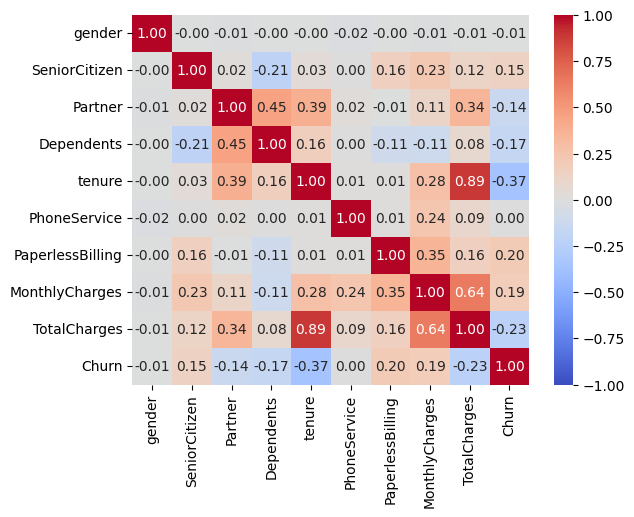

In [ ]:
sns.heatmap(corr_matrix.toArray(), xticklabels=num_feats, yticklabels=num_feats, annot = True,
            fmt = '.2f', vmin = -1., vmax = 1., cmap = 'coolwarm')

We make a list of the most target-correlated (and mostly independent) features:

In [ ]:
corr_feats = ['tenure', 'PaperlessBilling', 'MonthlyCharges', 'Dependents', 'SeniorCiziten']

<h3>Features distribution plots</h3>

To make graphs it's convenient to temporarily revert to Pandas DataFrame, due to the small size of this particular DataFrame we can convert it entirely, otherwise it's bettwe to collect a random sample of it:

In [ ]:
if TRAIN_SIZE <= 10000:
  sample_df = train.toPandas()
else:
  sample_df = train.sample(False, 10000/TRAIN_SIZE, seed = 7).toPandas()

<h4>Numerical features distributions</h4>

The histogram plots of numerical features show how all of them have not a normal distribution, morevorer TotalCharges is

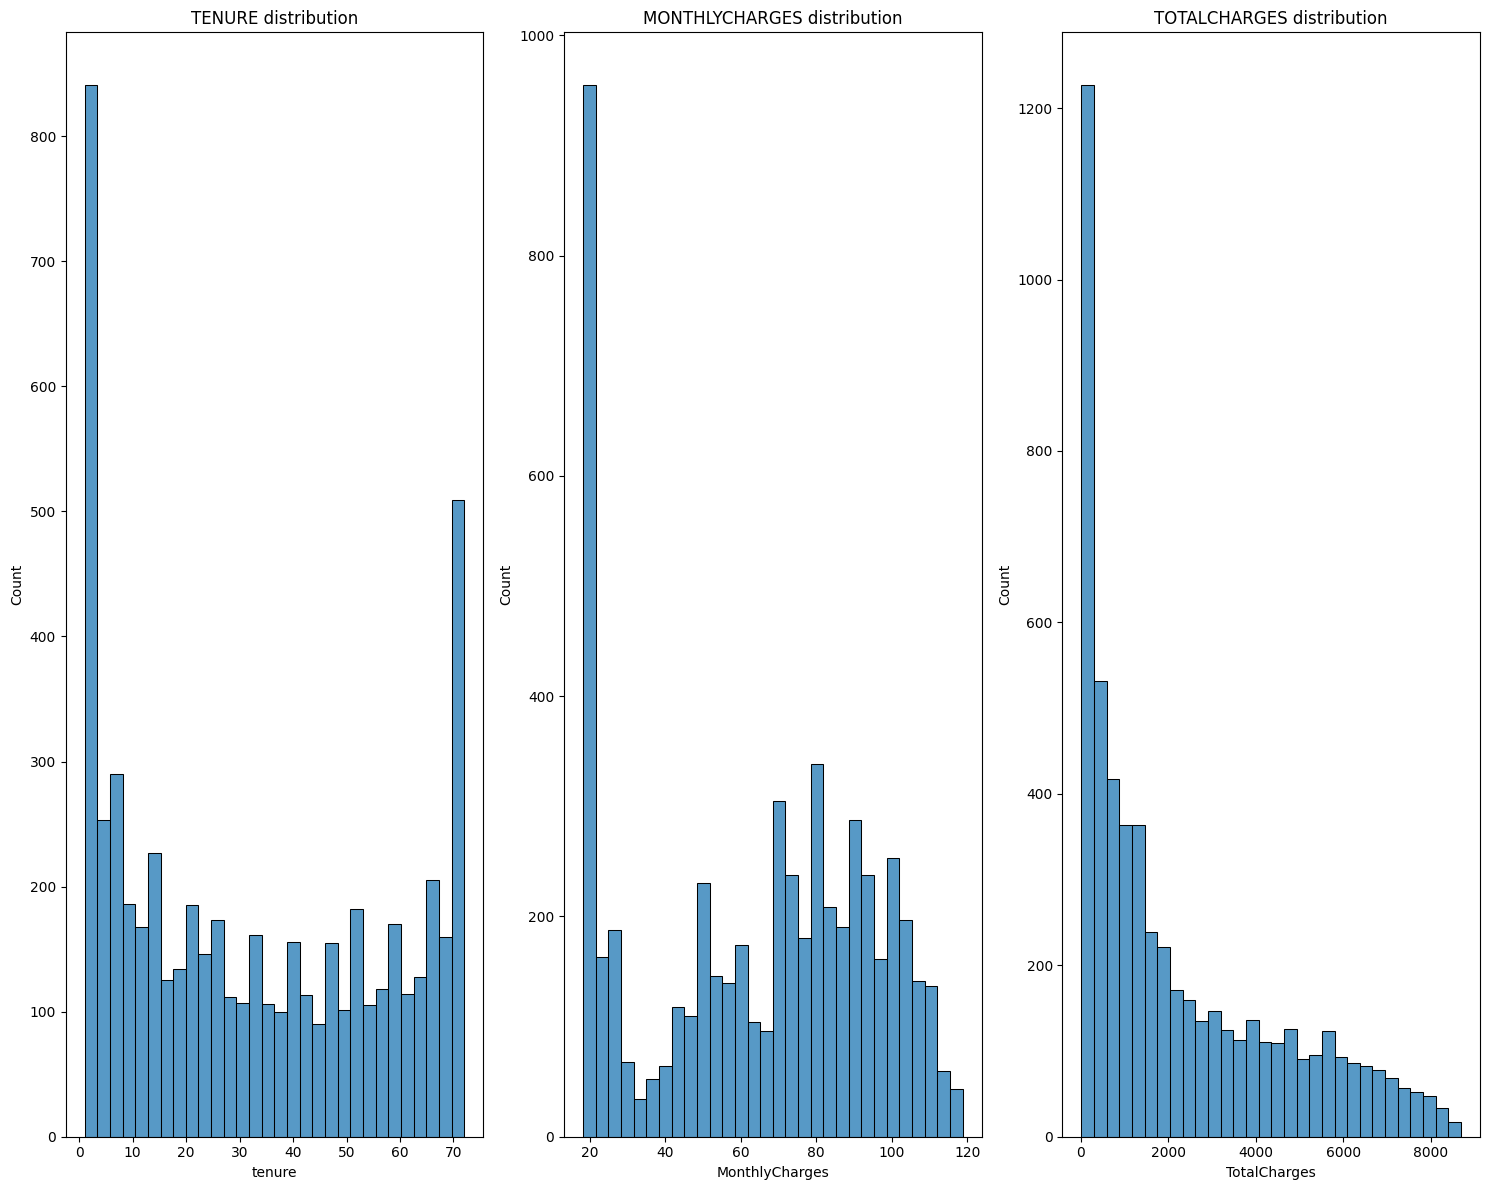

In [ ]:
rows = int(np.ceil(len(hc_feats) / 3.))
_, axes = plt.subplots(rows, 3, figsize =(15, 12))
for feat, ax in zip(hc_feats, axes.ravel()):
  sns.histplot(sample_df, x = feat, bins = 30, ax = ax)
  ax.set_title(f'{feat.upper()} distribution')
plt.tight_layout()
plt.show()

Plotting the distributions by Churn value show how the tenure distribution falls off quicker for churned customers than not-churned ones, which instead have a second peak and the upper limit of tenure values (maybe due to a data collection cutoff):

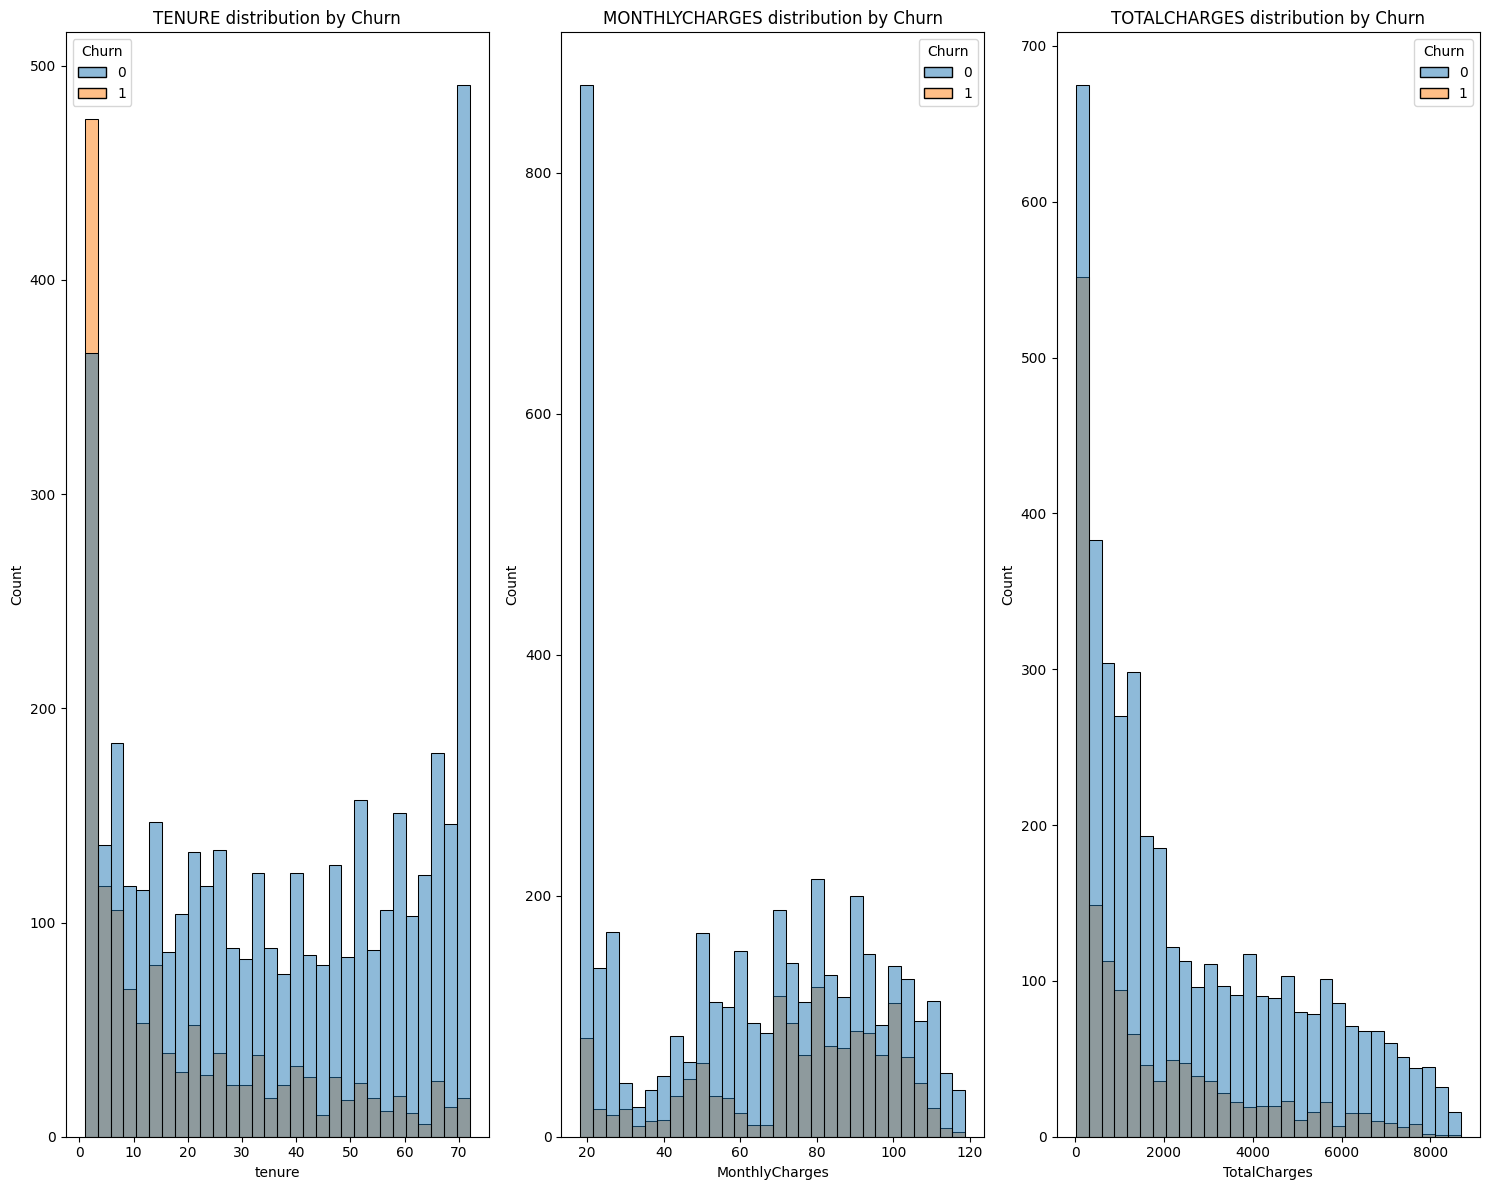

In [ ]:
rows = int(np.ceil(len(hc_feats) / 3.))
_, axes = plt.subplots(rows, 3, figsize =(15, 12))
for feat, ax in zip(hc_feats, axes.ravel()):
  sns.histplot(sample_df, x = feat, bins = 30, hue = 'Churn', ax = ax)
  ax.set_title(f'{feat.upper()} distribution by Churn')
plt.tight_layout()
plt.show()

<h4>Numerical features pairplot</h4>

Another useful visualization is to scatter plot the numerical features color coded by the target class: it's apparent how the space of tenure and TotalCharges/MonthlyCharges can be rougly divided in areas of high density of churned customer or not churned customer

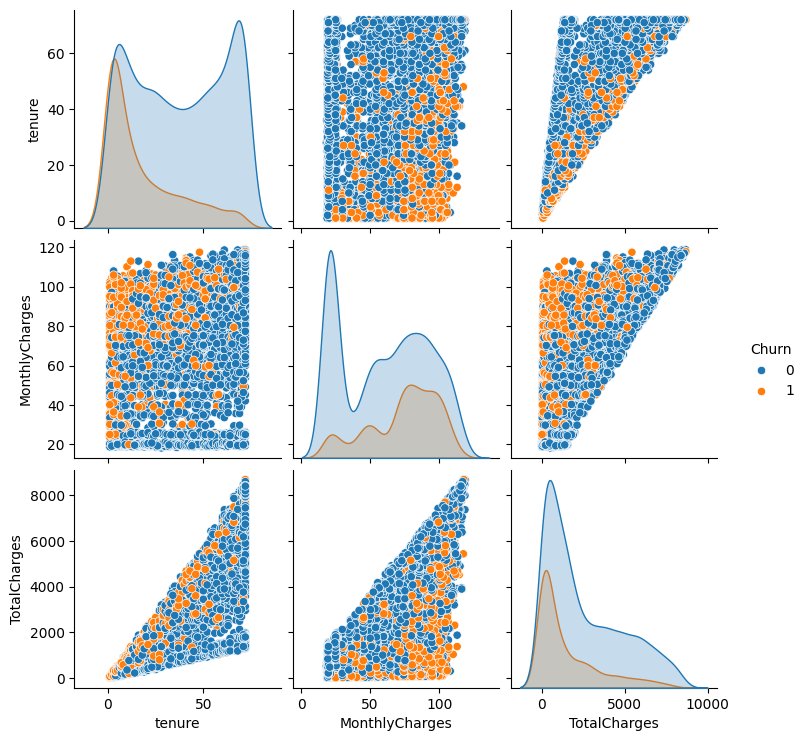

In [ ]:
sns.pairplot(sample_df, vars = hc_feats, hue = 'Churn')

<h4>Categorical distribution plots</h4>

We plot the distribution of categorical features:

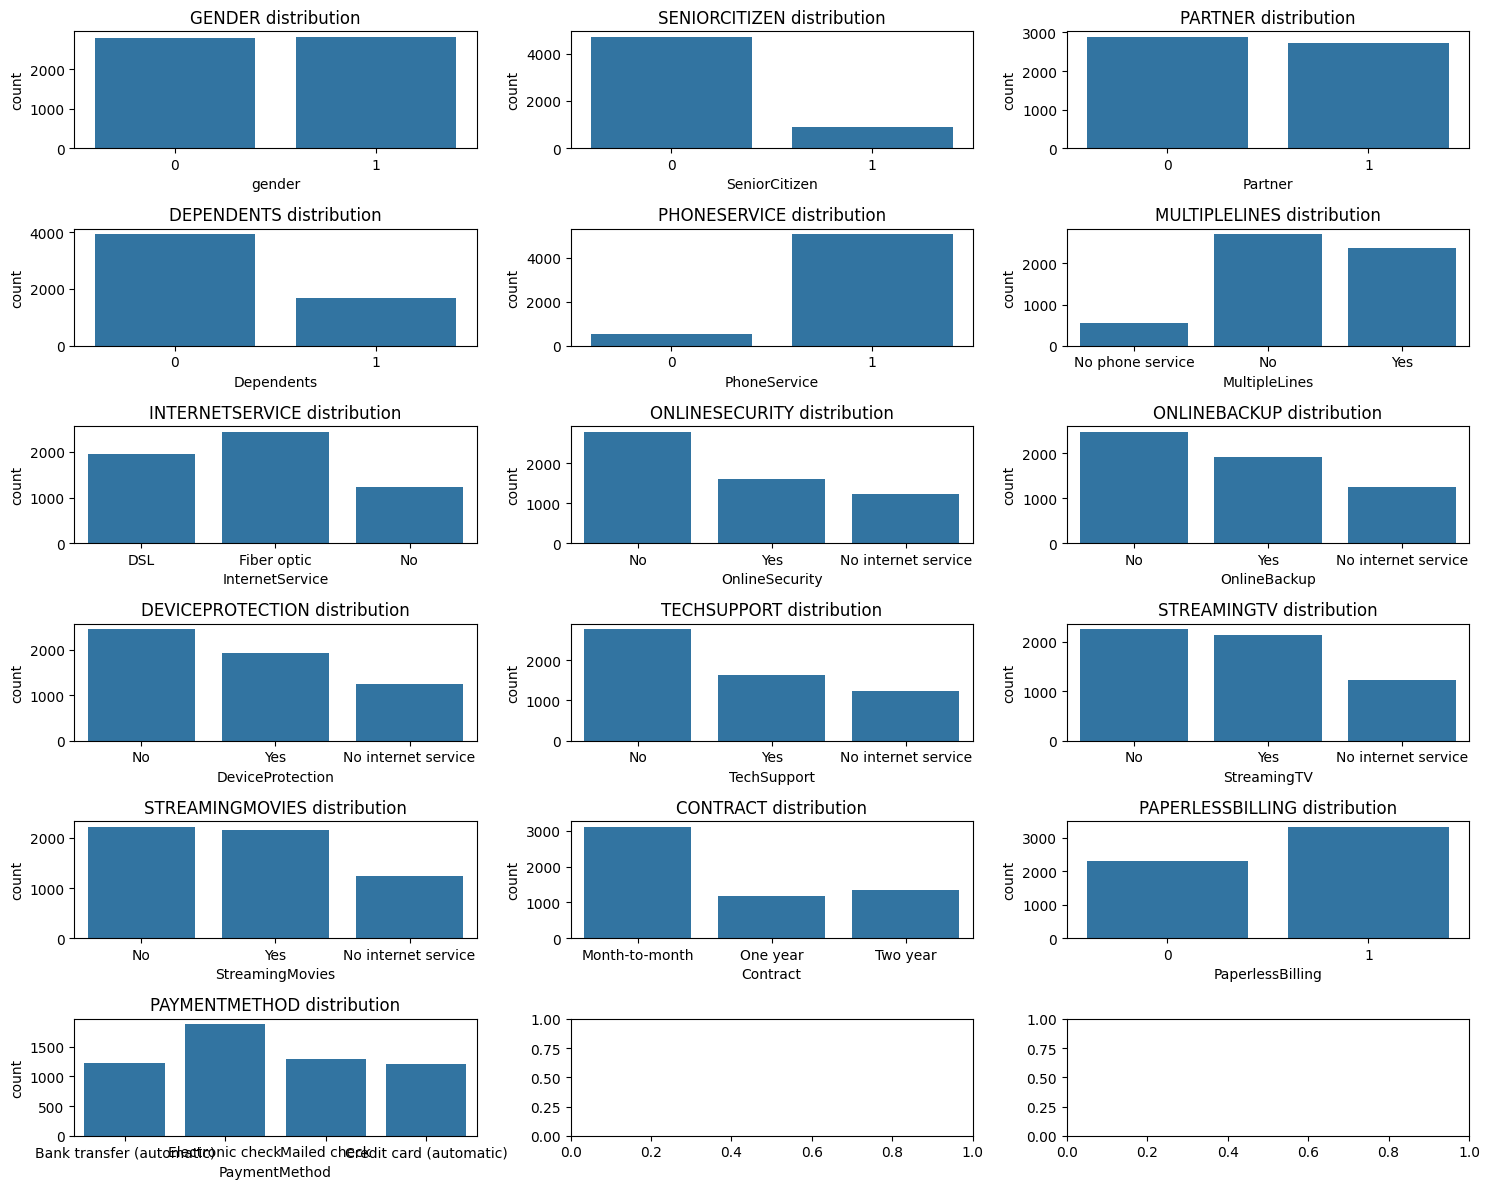

In [ ]:
rows = int(np.ceil(len(lc_feats) / 3.))
_, axes = plt.subplots(rows, 3, figsize =(15, 12))
for feat, ax in zip(lc_feats, axes.ravel()):
  sns.countplot(sample_df, x = feat, ax = ax)
  ax.set_title(f'{feat.upper()} distribution')
plt.tight_layout()
plt.show()

The distribution by Churn values shows how churned customers have significant different distribution regarding:
<ul>
<li>Online Security: most churned customer have no online security.</li>
<li>Online backup: most churned customer have no backup.</li>
<li>Device protection: most churned customer have no device protection.</li>
<li>Tech support: most churned customer did no require/make use of tech support.</li>
<li>Contracts: most churned customer have a month-to-month contract.</li>
</ul>

<ipython-input-96-5f5c9f57ca24>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


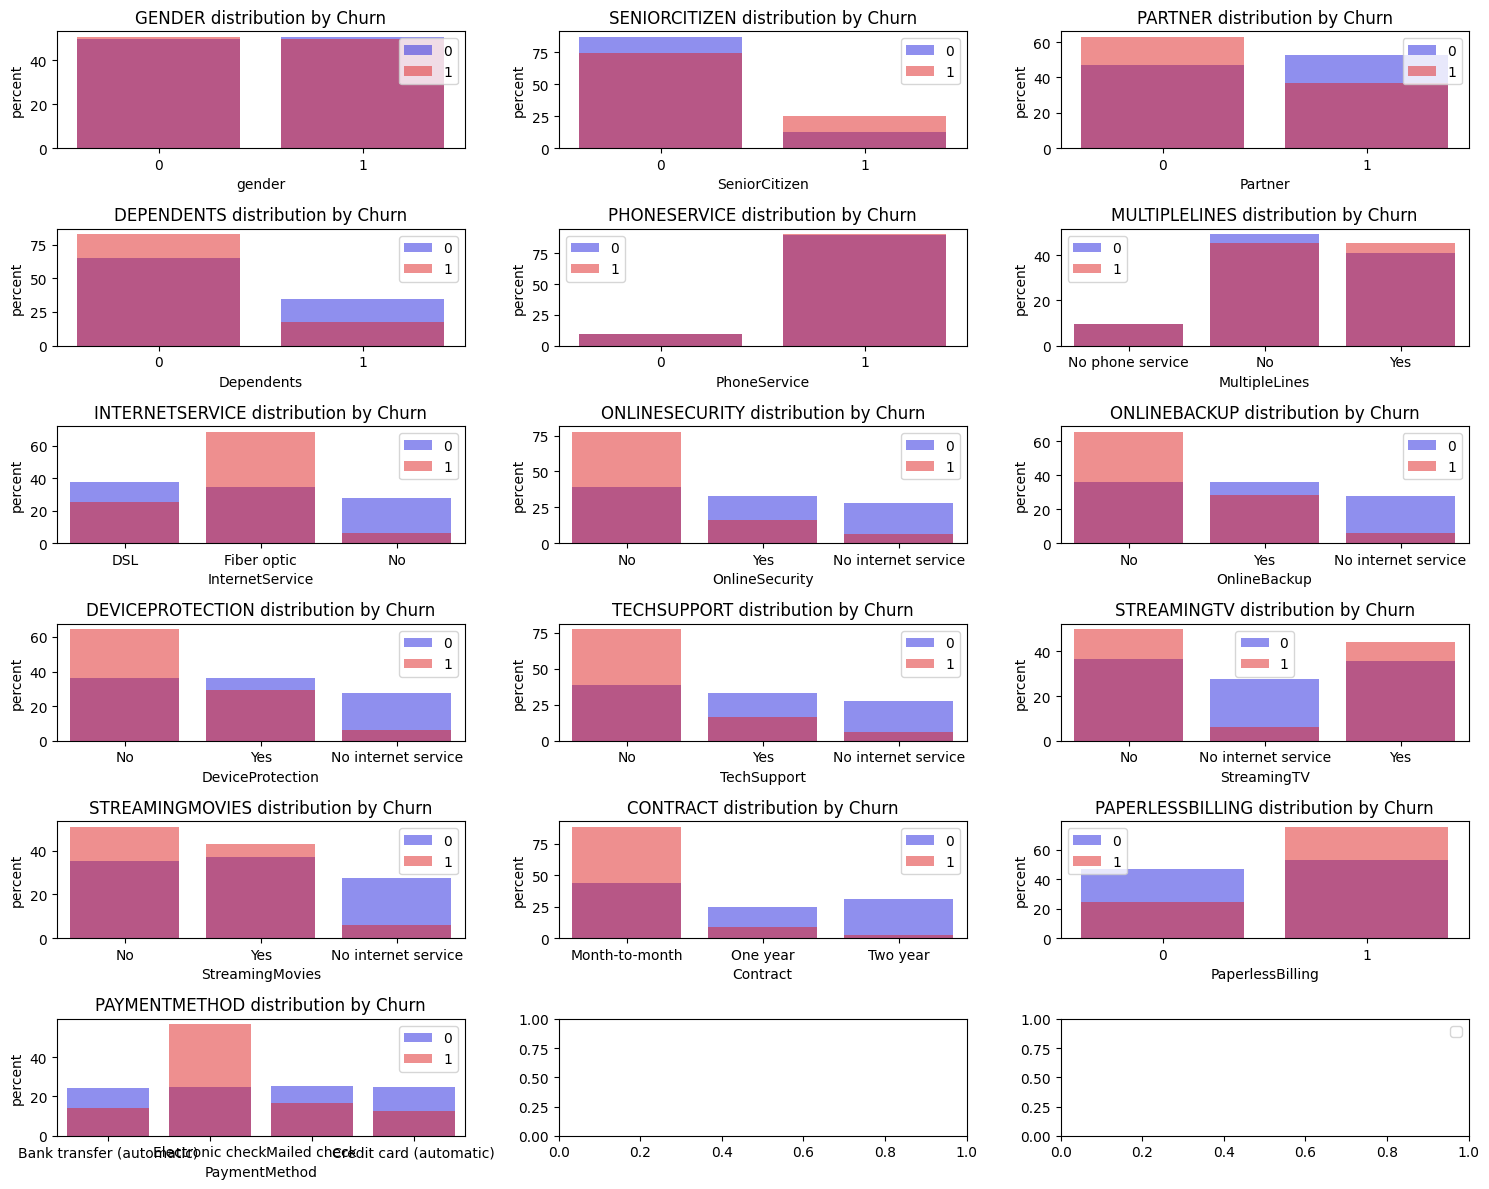

In [ ]:
rows = int(np.ceil(len(lc_feats) / 3.))
_, axes = plt.subplots(rows, 3, figsize =(15, 12))
sample_df_0 = sample_df[sample_df['Churn'] == 0]
sample_df_1 = sample_df[sample_df['Churn'] == 1]
for feat, ax in zip(lc_feats, axes.ravel()):
  sns.countplot(sample_df_0, x = feat, alpha = 0.5, color = 'blue', label = '0', stat = 'percent', ax = ax)
  sns.countplot(sample_df_1, x = feat, alpha = 0.5, color = 'red', label = '1', stat = 'percent', ax = ax)
  ax.set_title(f'{feat.upper()} distribution by Churn')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
cat_feats_selected = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract']

<h3>ML models</h3>

Now we're ready to apply a ML model: first we select the features we want the model to use and divide them in numerical (num_cols) and categorical (cat_cols); this distinction is made due the different preprocessing to apply:

In [ ]:
num_cols = list(set(hc_feats) & set(corr_feats))
cat_cols = list(set(lc_feats) & set(corr_feats)) + cat_feats_selected
print('Numerical features to model: ', num_cols)
print('Categorical features to model: ', cat_cols)

Numerical features to model:  ['MonthlyCharges', 'tenure']
Categorical features to model:  ['Dependents', 'PaperlessBilling', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract']


We also add a weights columns to handle the unbalanced classes problem: according to the Churn value we assign to each row a weights related to the Churn classes frequencies:

In [ ]:
train = train.withColumn('weights', when(col('Churn') == 0, 0.26).otherwise(0.74))
train.show(10, truncate = False)

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|weights|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------+
|0     |0            |0      |0         |1     |0           |No phone service|DSL            |No            |No          |No              |No         |No       

We write a function to perform:
<ul>
<li>Preprocessing: we set up assemblers to Standard Scale the numerical feature, One Hot Encode the categorical features and join the resulting columns in a feature vector.</li>
<li>Fitting: training the estimator on the training dataset.</li>
<li>Evaluation: we use the area under curve (AUC) of the receiver operating characteristic curve (ROC) to have an estimate of the goodness of the fit, the function also return the results DataFrame with the prediction for further analysis of the results if needed. </li>
</ul>

In [ ]:
def estimator_f(num_cols, cat_cols, label_col, model, train, test):
  num_assembler = MFT.VectorAssembler(inputCols = num_cols, outputCol = 'num_vector')
  num_scaler = MFT.StandardScaler(inputCol = 'num_vector', outputCol = 'num_scaled')
  cat_cols_idx = [x + '_idx' for x in cat_cols]
  cat_idx_assembler = MFT.StringIndexer(inputCols = cat_cols, outputCols = cat_cols_idx)
  cat_cols_idx_ohe = [x + '_idx' for x in cat_cols_idx]
  cat_ohe_assembler = MFT.OneHotEncoder(inputCols = cat_cols_idx, outputCols = cat_cols_idx_ohe)
  final_assembler = MFT.VectorAssembler(inputCols = ['num_scaled'] + cat_cols_idx_ohe, outputCol = 'features_vector')

  pipeline = Pipeline(stages = [num_assembler, num_scaler, cat_idx_assembler, cat_ohe_assembler, final_assembler, model])
  pipeline_fit = pipeline.fit(train)
  results = pipeline_fit.transform(test)
  res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol = label_col)

  ROC_AUC = res.evaluate(results)
  print("ROC-AUC: {:.4f}".format(ROC_AUC))
  return results

As a first model we use a Logistic Regressor:

In [ ]:
lr = LogisticRegression(featuresCol = 'features_vector', labelCol = 'Churn', weightCol = 'weights')

results_lr = estimator_f(num_cols = num_cols, cat_cols = cat_cols, label_col = 'Churn', model = lr, train = train, test = test)

ROC-AUC: 0.7641


We also plot the confusion matrix as a different view of the results:

<Axes: ylabel='Churn'>

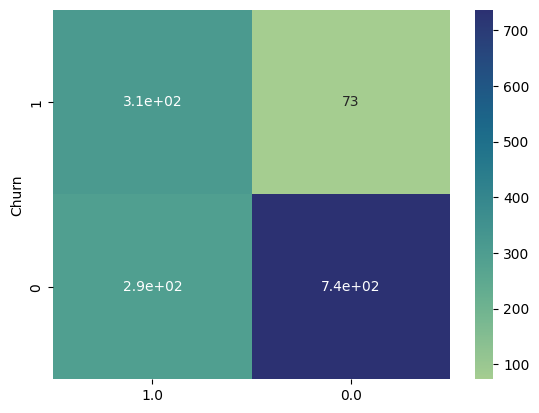

In [ ]:
confusion_matrix = results_lr.groupBy('Churn').pivot('prediction').count().toPandas().set_index('Churn').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False).fillna(0).astype(int)
sns.heatmap(confusion_matrix, cmap = 'crest', annot = True)

We repeat the same procedure for a Random Forest Classifier:

In [ ]:
rfc = RandomForestClassifier(featuresCol = 'features_vector', labelCol = 'Churn',
                             numTrees = 100, minInstancesPerNode = 3, maxDepth=7, weightCol = 'weights')

results_rfc = estimator_f(num_cols = num_cols, cat_cols = cat_cols, label_col = 'Churn', model = rfc, train = train, test = test)

ROC-AUC: 0.7770


<Axes: ylabel='Churn'>

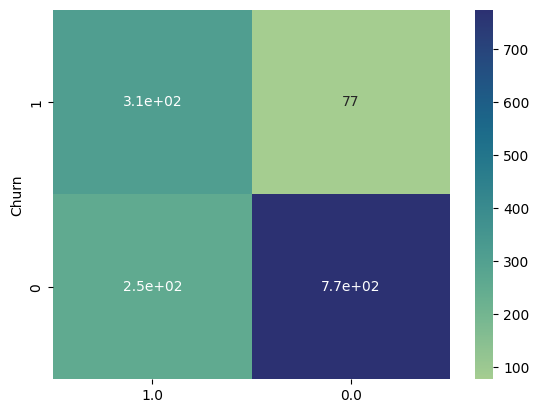

In [ ]:
confusion_matrix_rfc = results_rfc.groupBy('Churn').pivot('prediction').count().toPandas().set_index('Churn').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False).fillna(0).astype(int)
sns.heatmap(confusion_matrix_rfc, cmap = 'crest', annot = True)